In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import pickle

In [42]:
df = pd.read_csv('processed_energy_data_1.csv')

C:\Users\ssttg\AppData\Local\Temp\ipykernel_18904\119361038.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('processed_energy_data_1.csv')


In [43]:
df.head(1)

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,dewPoint,precipProbability,total_energy_use,net_energy,hour,day,month,daily_cost,is_off_peak,tariff_rate
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.0207,0.061917,0.442633,0.12415,0.006983,...,24.4,0.0,2.58065,-2.577167,5,1,1,25.8065,1,1.0


In [44]:
def categorize_consumption(value):
    if value < 1.0:
        return 'Low'
    elif 1.0 <= value < 2.0:
        return 'Medium'
    else:
        return 'High'

In [49]:
# Define features and target variables
X = df[['hour', 'day', 'month', 'temperature', 'tariff_rate']]
y_consumption = df['use [kW]'].apply(categorize_consumption)
y_generation = df['gen [kW]']

In [51]:
# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_consumption)

In [54]:
# Split he data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [56]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (403128, 5) (403128,)
Testing set shape: (100782, 5) (100782,)


# MODEL

In [58]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=69)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=69)

In [66]:
# Make predictions
y_pred_prob = model.predict(X_test)

In [67]:
def predict_category(value):
    if value < 1.0:
        return 0  # Low
    elif 1.0 <= value < 2.0:
        return 1  # Medium
    else:
        return 2  # High


In [68]:
# Apply the prediction function
y_pred = np.array([predict_category(pred) for pred in y_pred_prob])


In [90]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.30277232045404934


In [84]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

Accuracy Score: 73.62%


In [86]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:\n", cm)


 Confusion Matrix:
 [[ 3834  2203     1]
 [ 6876 70200     2]
 [ 1308 16197   161]]


In [88]:
# Classification Report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\n Classification Report:\n", report)


 Classification Report:
               precision    recall  f1-score   support

        High       0.32      0.63      0.42      6038
         Low       0.79      0.91      0.85     77078
      Medium       0.98      0.01      0.02     17666

    accuracy                           0.74    100782
   macro avg       0.70      0.52      0.43    100782
weighted avg       0.80      0.74      0.68    100782



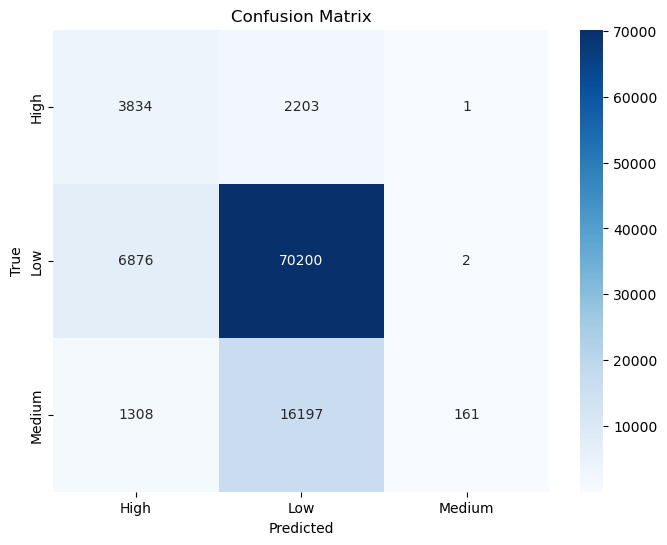

In [76]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Recommandation

In [95]:
def provide_recommendations(forecasted_consumption, forecasted_tariffs):
    recommendations = []
    for consumption, tariff in zip(forecasted_consumption, forecasted_tariffs):
        if tariff < 2.0 and consumption > 2.5:  # Low tariff, high consumption
            recommendations.append("Consider running high-energy appliances now to save on costs.")
        elif tariff >= 3.0 and consumption < 2.0:  # High tariff, low consumption
            recommendations.append("Reduce energy consumption or shift usage to off-peak hours.")
        else:
            recommendations.append("Current energy usage is optimal.")
    return recommendations

# Simulate forecasted consumption and tariffs for the next 24 hours
future_consumption = model.predict(X_test[:24])  # Predict for the next 24 hours
future_tariffs = np.random.choice([1.0, 2.5, 3.5, 4.0], 24)  # Simulated future tariffs

# Get recommendations based on forecast
recommendations = provide_recommendations(future_consumption, future_tariffs)

# Display recommendations
for i, rec in enumerate(recommendations):
    print(f"Hour {i}: {rec}")


Hour 0: Current energy usage is optimal.
Hour 1: Current energy usage is optimal.
Hour 2: Reduce energy consumption or shift usage to off-peak hours.
Hour 3: Reduce energy consumption or shift usage to off-peak hours.
Hour 4: Reduce energy consumption or shift usage to off-peak hours.
Hour 5: Current energy usage is optimal.
Hour 6: Reduce energy consumption or shift usage to off-peak hours.
Hour 7: Current energy usage is optimal.
Hour 8: Reduce energy consumption or shift usage to off-peak hours.
Hour 9: Reduce energy consumption or shift usage to off-peak hours.
Hour 10: Reduce energy consumption or shift usage to off-peak hours.
Hour 11: Reduce energy consumption or shift usage to off-peak hours.
Hour 12: Reduce energy consumption or shift usage to off-peak hours.
Hour 13: Reduce energy consumption or shift usage to off-peak hours.
Hour 14: Reduce energy consumption or shift usage to off-peak hours.
Hour 15: Reduce energy consumption or shift usage to off-peak hours.
Hour 16: Curre

In [97]:
def generate_recommendations(hour, tariff_rate, usage_prediction, threshold=2.5):
    if tariff_rate < threshold and usage_prediction < 1.0:
        return "Recommended to run high-energy appliances."
    elif tariff_rate >= threshold:
        return "Avoid using high-energy appliances due to high tariffs."
    else:
        return "Normal usage recommended."

# Example usage
for idx, row in X_test.iterrows():
    usage_pred = model.predict([row])[0]
    recommendation = generate_recommendations(row['hour'], row['tariff_rate'], usage_pred)
    print(f"Hour: {row['hour']}, Tariff: {row['tariff_rate']}, Recommendation: {recommendation}")

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, R

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, R

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using hi

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recom

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tari

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avo

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avo

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Re

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: A

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Ho

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-ener

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-en

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommend

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Reco

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recomm

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommend

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0,

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Reco

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tarif

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommend

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Norma

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-ene

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recomm

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Reco

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using hig

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recomm

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high t

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid us

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Av

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Re

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy applia

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoi

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recom

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high t

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recomm

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high t

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recom

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommen

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high ta

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, T

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-ene

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances d

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-e

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommen

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-e

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommen

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Reco

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recomme

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tari

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-ener

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, R

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-ene

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tarif

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: N

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommen

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-e

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recomme

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances du

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recomme

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommen

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tari

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-en

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high ta

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy applian

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoi

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Reco

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendat

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Re

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-e

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, R

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energ

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 19.0, Tariff: 4.0, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariff

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high ta

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recomm

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, Tariff: 1.0, Recommendation: Normal usage recommend

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 3.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 10.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 6.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 0.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 4.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 19.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 3.0, 

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 17.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 2.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 12.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Rec

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 11.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appliances.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 5.0, Tariff: 1.0, Recommendation: Normal usage recommended.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommendation: Recommended to run high-energy appl

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 22.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 9.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 7.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 14.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 20.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 1.0, Tariff: 1.0, Recommend

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 23.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 13.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 16.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 8.0, Tariff: 2.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 18.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 15.0, Tariff: 3.5, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 21.0, Tariff: 4.0, Recommendation: Avoid using high-energy appliances due to high tariffs.
Hour: 12.0, Tariff: 3.5, Recomme

C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssttg\anaconda3\Lib\site-packages\sklearn\base.py:493: U

KeyboardInterrupt: 

#### Saving model

In [104]:
#joblib.dump(model, 'energy_forecasting_model.joblib')

['energy_forecasting_model.joblib']

In [106]:
#with open('energy_forecasting_model.pkl', 'wb') as file:
#    pickle.dump(model, file)

#### Importing model

In [109]:
# Load the model from a file
loaded_model = joblib.load('energy_forecasting_model.joblib')

# Example prediction
prediction = loaded_model.predict(X_test[:1])
print(f"Predicted energy usage: {prediction[0]}")

Predicted energy usage: 1.0


In [119]:
# Load the model from a file
with open('energy_forecasting_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Example prediction
prediction = loaded_model.predict(X_test[:100])
print(f"Predicted energy usage: {prediction[99]}")

Predicted energy usage: 1.0


# REcommandation using model

In [122]:
# Load the trained model
model = joblib.load('energy_forecasting_model.joblib')

def generate_recommendations(hour, tariff_rate, usage_prediction, threshold=2.5):
    if tariff_rate < threshold and usage_prediction < 1.0:
        return "Recommended to run high-energy appliances."
    elif tariff_rate >= threshold:
        return "Avoid using high-energy appliances due to high tariffs."
    else:
        return "Normal usage recommended."

def predict_and_recommend(input_data):
    # Assuming input_data is a Pandas DataFrame with the required columns
    usage_prediction = model.predict(input_data)[0]
    return generate_recommendations(input_data['hour'].values[0], 
                                    input_data['tariff_rate'].values[0], 
                                    usage_prediction)